# BAT.jl Tutorial

This tutorial demonstrates a simple application of BAT.jl: A Bayesian fit
of a histogram with two Gaussian peaks.



Note: This tutorial is somewhat verbose, as it aims to be easy to follow for
users who are new to Julia. For the same reason, we deliberately avoid making
use of Julia features like
[closures](https://docs.julialang.org/en/v1/devdocs/functions/#Closures-1),
[anonymous functions](https://docs.julialang.org/en/v1/manual/functions/index.html#man-anonymous-functions-1),
[broadcasting syntax](https://docs.julialang.org/en/v1/manual/arrays/index.html#Broadcasting-1),
[performance annotations](https://docs.julialang.org/en/v1/manual/performance-tips/#man-performance-annotations-1),
etc.

## Input Data Generation

First, let's generate some synthetic data to fit. We'll need the Julia
standard-library packages
["Random"](https://docs.julialang.org/en/v1/stdlib/Random/),
["LinearAlgebra"](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/)
and ["Statistics"](https://docs.julialang.org/en/v1/stdlib/Statistics/),
as well as the packages
["Distributions"](https://juliastats.org/Distributions.jl/stable/)
and ["StatsBase"](https://juliastats.org/StatsBase.jl/stable/):

In [2]:
using Pkg

In [3]:
Pkg.add("StatsBase")

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
⌅ [2913bbd2] + StatsBase v0.33.21
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
Precompiling project...
  ✓ Distributions → DistributionsTestExt
  ✓ AbstractMCMC
  ✓ Distributions → DistributionsDensityInterfaceExt
  ✓ AbstractPPL
  ✓ Plots → UnitfulExt
  ✓ Distributions → DistributionsChainRulesCoreExt
  ✓ AdvancedHMC
  ✓ MCMCDiagnosticTools
  ✓ KernelDensity
  ✓ Plots → IJuliaExt
  ✓ AdvancedPS
  ✓ Bijectors
  ✓ AdvancedMH
  ✓ EllipticalSliceSampling
  ✓ DistributionsAD
  ✓ AdvancedPS → AdvancedPSLibtaskExt
  ✓ MCMCChains
  ✓ AdvancedHMC → AdvancedHMCMCMCChainsExt
  ✓ AdvancedMH → AdvancedMHMCMCChainsExt
  ✓ DistributionsAD → DistributionsADTrackerExt
  ✓ Bijectors → BijectorsTrackerExt
  ✓ AdvancedMH → AdvancedMHForwardDiffExt
  ✓ Bijectors → BijectorsDistributionsADExt
  ✓ AdvancedMH → AdvancedMHStructArraysExt
  ✓ AdvancedVI
  ✓ DynamicPPL
  ✓ DynamicPPL → DynamicPPLZygoteRulesEx

In [4]:
using Random, LinearAlgebra, Statistics, Distributions, StatsBase

As the underlying truth of our input data/histogram, let us choose the
expected count to follow the sum of two Gaussian peaks with peak
areas of 500 and 1000, a mean of -1.0 and 2.0 and a standard error of 0.5.
Then

In [5]:
data = vcat(
    rand(Normal(-1.0, 0.5), 500),
    rand(Normal( 2.0, 0.5), 1000)
)

1500-element Vector{Float64}:
 -0.9589421611188486
 -0.15791705299506398
 -1.3203296093330565
 -0.8419318446738383
 -1.753914241376107
 -1.391900631160781
 -1.5617834392889698
 -1.338524807242932
 -0.19329992509121063
 -0.27537301113818835
 -1.3722210882591328
 -0.7958600206649431
 -1.1679879540184075
  ⋮
  1.7111567979008726
  0.43299329330368064
  2.4102109615966656
  1.7631720355963043
  2.26752019456241
  2.586977103669412
  1.6321205842748416
  1.9755673095749355
  2.3201862462941127
  2.368826347401276
  1.8574556681067615
  3.026392938921081

resulting in a vector of floating-point numbers:

In [6]:
typeof(data) == Vector{Float64}

true

Next, we'll create a histogram of that data, this histogram will serve as
the input for the Bayesian fit:

In [7]:
hist = append!(Histogram(-2:0.1:4), data)

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -2.0:0.1:4.0
weights: [6, 9, 14, 15, 19, 32, 31, 28, 30, 34  …  19, 4, 3, 3, 2, 0, 1, 0, 0, 0]
closed: left
isdensity: false

Using the Julia ["Plots"](http://docs.juliaplots.org/latest/) package

In [8]:
using Plots

we can plot the histogram:

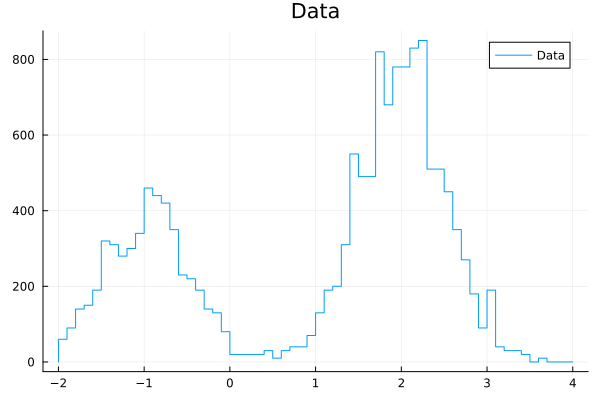

In [9]:
plot(
    normalize(hist, mode=:density),
    st = :steps, label = "Data",
    title = "Data"
)

Let's define our fit function - the function that we expect to describe the
data histogram, at each x-Axis position `x`, depending on a given set `p` of
model parameters:

In [10]:
function fit_function(p::NamedTuple{(:a, :mu, :sigma)}, x::Real)
    p.a[1] * pdf(Normal(p.mu[1], p.sigma), x) +
    p.a[2] * pdf(Normal(p.mu[2], p.sigma), x)
end

fit_function (generic function with 1 method)

The fit parameters (model parameters) `a` (peak areas) and `mu` (peak means)
are vectors, parameter `sigma` (peak width) is a scalar, we assume it's the
same for both Gaussian peaks.

The true values for the model/fit parameters are the values we used to
generate the data:

In [11]:
true_par_values = (a = [500, 1000], mu = [-1.0, 2.0], sigma = 0.5)

(a = [500, 1000], mu = [-1.0, 2.0], sigma = 0.5)

Let's visually compare the histogram and the fit function, using these true
parameter values, to make sure everything is set up correctly:

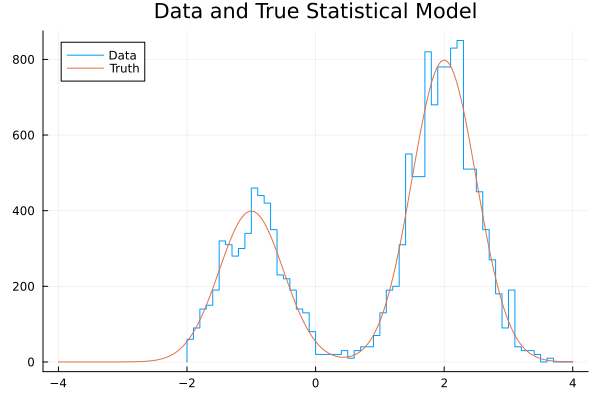

In [12]:
plot(
    normalize(hist, mode=:density),
    st = :steps, label = "Data",
    title = "Data and True Statistical Model"
)
plot!(
    -4:0.01:4, x -> fit_function(true_par_values, x),
    label = "Truth"
)

## Bayesian Fit

Now we'll perform a Bayesian fit of the generated histogram, using BAT,
to infer the model parameters from the data histogram.

In addition to the Julia packages loaded above, we need BAT itself, as
well as [IntervalSets](https://github.com/JuliaMath/IntervalSets.jl):

In [13]:
Pkg.add("BAT")

   Resolving package versions...
   Installed HeterogeneousComputing ── v0.2.2
   Installed AbstractMCMC ──────────── v4.4.2
   Installed MeasureBase ───────────── v0.14.7
   Installed AdvancedPS ────────────── v0.4.3
   Installed Accessors ─────────────── v0.1.33
   Installed DoubleFloats ──────────── v1.3.0
   Installed Turing ────────────────── v0.29.3
   Installed EllipticalSliceSampling ─ v1.1.0
   Installed ArraysOfArrays ────────── v0.6.4
   Installed Static ────────────────── v0.8.8
   Installed EmpiricalDistributions ── v0.3.7
   Installed AutoDiffOperators ─────── v0.1.7
   Installed Polynomials ───────────── v4.0.6
   Installed FunctionChains ────────── v0.1.5
   Installed IfElse ────────────────── v0.1.1
   Installed ValueShapes ───────────── v0.10.14
   Installed DynamicPPL ────────────── v0.23.21
   Installed AffineMaps ────────────── v0.2.3
   Installed AbstractDifferentiation ─ v0.6.0
   Installed PrettyPrinting ────────── v0.4.1
   Installed AbstractPPL ───────────── v

  ✓ Accessors → AccessorsStaticArraysExt
  ✓ AbstractDifferentiation → AbstractDifferentiationForwardDiffExt
  ✓ BangBang → BangBangTypedTablesExt
  ✓ AbstractDifferentiation → AbstractDifferentiationChainRulesCoreExt
  ✓ EmpiricalDistributions
  ✓ AutoDiffOperators
  ✓ MeasureBase
  ✓ AbstractMCMC
  ✓ AutoDiffOperators → AutoDiffOperatorsForwardDiffExt
  ✓ ValueShapes
  ✓ AbstractPPL
  ✓ AdvancedPS
  ✓ AdvancedMH
  ✓ EllipticalSliceSampling
  ✓ AdvancedHMC
  ✓ MCMCChains
  ✓ AdvancedHMC → AdvancedHMCMCMCChainsExt
  ✓ AdvancedMH → AdvancedMHMCMCChainsExt
  ✓ AdvancedMH → AdvancedMHForwardDiffExt
  ✓ AdvancedMH → AdvancedMHStructArraysExt
  ✓ DynamicPPL
  ✓ DynamicPPL → DynamicPPLMCMCChainsExt
  ✓ Polynomials
  ✓ Polynomials → PolynomialsFFTWExt
  ✓ Polynomials → PolynomialsChainRulesCoreExt
  ✓ Turing
  ✓ DoubleFloats
  ✓ BAT
  ✓ BAT → BATAdvancedHMCExt
  ✓ BAT → BATPlotsExt
  76 dependencies successfully precompiled in 144 seconds. 356 already precompiled.


In [14]:
Pkg.add("IntervalSets")

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [8197267c] + IntervalSets v0.7.8
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
Precompiling project...
  ✓ AbstractDifferentiation → AbstractDifferentiationTrackerExt
  1 dependency successfully precompiled in 4 seconds. 431 already precompiled.


In [16]:
Pkg.add("DensityInterface")

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [b429d917] + DensityInterface v0.4.0
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [17]:
using BAT, DensityInterface, IntervalSets

### Likelihood Definition

First, we need to define the likelihood (function) for our problem.

BAT represents densities like likelihoods and priors as subtypes of
`BAT.AbstractMeasureOrDensity`. Custom likelihood can be defined by
creating a new subtype of `AbstractMeasureOrDensity` and by implementing (at minimum)
`DensityInterface.logdensityof` for that type - in complex uses cases, this may
become necessary. Typically, however, it is sufficient to define a custom
likelihood as a simple function that returns the log-likelihood value for
a given set of parameters. BAT will automatically convert such a
likelihood function into a subtype of `AbstractMeasureOrDensity`.

For performance reasons, functions should [not access global variables
directly] (https://docs.julialang.org/en/v1/manual/performance-tips/index.html#Avoid-global-variables-1).
So we'll use an [anonymous function](https://docs.julialang.org/en/v1/manual/functions/#man-anonymous-functions-1)
inside of a [let-statement](https://docs.julialang.org/en/v1/base/base/#let)
to capture the value of the global variable `hist` in a local variable `h`
(and to shorten function name `fit_function` to `f`, purely for
convenience). `DensityInterface.logfuncdensity` turns a log-likelihood
function into a density object.

In [18]:
likelihood = let h = hist, f = fit_function
    # Histogram counts for each bin as an array:
    observed_counts = h.weights

    # Histogram binning:
    bin_edges = h.edges[1]
    bin_edges_left = bin_edges[1:end-1]
    bin_edges_right = bin_edges[2:end]
    bin_widths = bin_edges_right - bin_edges_left
    bin_centers = (bin_edges_right + bin_edges_left) / 2

    logfuncdensity(function (params)
        # Log-likelihood for a single bin:
        function bin_log_likelihood(i)
            # Simple mid-point rule integration of fit function `f` over bin:
            expected_counts = bin_widths[i] * f(params, bin_centers[i])
            # Avoid zero expected counts for numerical stability:
            logpdf(Poisson(expected_counts + eps(expected_counts)), observed_counts[i])
        end

        # Sum log-likelihood over bins:
        idxs = eachindex(observed_counts)
        ll_value = bin_log_likelihood(idxs[1])
        for i in idxs[2:end]
            ll_value += bin_log_likelihood(i)
        end

        return ll_value
    end)
end

LogFuncDensity(var"#3#4"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Vector{Int64}, typeof(fit_function)}(-1.95:0.1:3.95, StepRangeLen(0.1, 0.0, 60), [6, 9, 14, 15, 19, 32, 31, 28, 30, 34  …  19, 4, 3, 3, 2, 0, 1, 0, 0, 0], fit_function))

BAT makes use of Julia's parallel programming facilities if possible, e.g.
to run multiple Markov chains in parallel. Therefore, log-likelihood
(and other) code must be thread-safe. Mark non-thread-safe code with
`@critical` (provided by Julia package `ParallelProcessingTools`).

Support for automatic parallelization across multiple (local and remote)
Julia processes is planned, but not implemented yet.

Note that Julia currently starts only a single thread by default. Set the
the environment variable
[`JULIA_NUM_THREADS`](https://docs.julialang.org/en/v1/manual/environment-variables/#JULIA_NUM_THREADS-1)
to specify the desired number of Julia threads.

We can evaluate `likelihood`, e.g. at the true parameter values:

In [19]:
logdensityof(likelihood, true_par_values)

-152.07308612268403

### Prior Definition

Next, we need to choose a sensible prior for the fit:

In [20]:
prior = distprod(
    a = [Weibull(1.1, 5000), Weibull(1.1, 5000)],
    mu = [-2.0..0.0, 1.0..3.0],
    sigma = Weibull(1.2, 2)
)

NamedTupleDist((a = Product{Continuous, Weibull{Float64}, Vector{Weibull{Float64}}}(v=Weibull{Float64}[Weibull{Float64}(α=1.1, θ=5000.0), Weibull{Float64}(α=1.1, θ=5000.0)]), mu = Product{Continuous, Uniform{Float64}, Vector{Uniform{Float64}}}(v=Uniform{Float64}[Uniform{Float64}(a=-2.0, b=0.0), Uniform{Float64}(a=1.0, b=3.0)]), sigma = Weibull{Float64}(α=1.2, θ=2.0)))

In general, BAT allows instances of any subtype of `AbstractMeasureOrDensity` to
be uses as a prior, as long as a sampler is defined for it. This way, users
may implement complex application-specific priors. You can also
use `convert(AbstractMeasureOrDensity, distribution)` to convert any
continuous multivariate `Distributions.Distribution` to a
`BAT.AbstractMeasureOrDensity` that can be used as a prior (or likelihood).

### Bayesian Model Definition

Given the likelihood and prior definition, a `BAT.PosteriorMeasure` is simply
defined via

In [21]:
posterior = PosteriorMeasure(likelihood, prior)

PosteriorMeasure(objectid = 0x293dce88e19b7001, varshape = NamedTupleShape((:a, :mu, :sigma)}(…))

### Parameter Space Exploration via MCMC

We can now use Markov chain Monte Carlo (MCMC) to explore the space of
possible parameter values for the histogram fit.

To increase the verbosity level of BAT logging output, you may want to set
the Julia logging level for BAT to debug via `ENV["JULIA_DEBUG"] = "BAT"`.

In [22]:
ENV["JULIA_DEBUG"] = "BAT"

"BAT"

Now we can generate a set of MCMC samples via `bat_sample`. We'll
use 4 MCMC chains with 10^5 MC steps in each chain (after tuning/burn-in):

In [23]:
samples = bat_sample(posterior, MCMCSampling(mcalg = MetropolisHastings(), nsteps = 10^5, nchains = 4)).result
nothing # hide

[ Info: Setting new default BAT context BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0x5e49c23481bb8b0f, 0x90de5bfe0ee430a5, 0x9bbf846f64ba7f7a, 0x01f8fcb061dc2469, 0x05a213f585a80e3c, 0x090e5cbfd2cfc992, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), HeterogeneousComputing.CPUnit(), BAT._NoADSelected())
[ Info: MCMCChainPoolInit: trying to generate 4 viable MCMC chain(s).
┌ Debug: Generating dummy MCMC chain to determine chain, output and tuner types.
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/chain_pool_init.jl:80
┌ Debug: Generating 32 candidate MCMC chain(s).
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/chain_pool_init.jl:94
┌ Debug: Testing 32 candidate MCMC chain(s).
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/chain_pool_init.jl:106
┌ Debug: Starting iteration over 32 MCMC chain(s)
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:266
┌ Debug: Starting iteration over MCMC chain 1 with 5

┌ Debug: Found 32 viable MCMC chain(s).
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/chain_pool_init.jl:120
┌ Debug: Starting iteration over 32 MCMC chain(s)
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:266
┌ Debug: Starting iteration over MCMC chain 1 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 2 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 3 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 4 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 5 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:2

┌ Debug: Found 32 MCMC chain(s) with at least 11 unique accepted samples.
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/chain_pool_init.jl:132
┌ Debug: Generating 32 additional candidate MCMC chain(s).
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/chain_pool_init.jl:94
┌ Debug: Testing 32 candidate MCMC chain(s).
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/chain_pool_init.jl:106
┌ Debug: Starting iteration over 32 MCMC chain(s)
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:266
┌ Debug: Starting iteration over MCMC chain 33 with 50 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 34 with 50 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 35 with 50 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Star

┌ Debug: Found 31 viable MCMC chain(s).
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/chain_pool_init.jl:120
┌ Debug: Starting iteration over 31 MCMC chain(s)
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:266
┌ Debug: Starting iteration over MCMC chain 33 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 34 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 35 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 36 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 37 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm

┌ Debug: Found 31 MCMC chain(s) with at least 11 unique accepted samples.
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/chain_pool_init.jl:132
[ Info: Selected 4 MCMC chain(s).
[ Info: Begin tuning of 4 MCMC chain(s).
┌ Debug: Starting iteration over 4 MCMC chain(s)
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:266
┌ Debug: Starting iteration over MCMC chain 8 with 10000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 29 with 10000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 40 with 10000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 61 with 10000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Finished iteration over M

┌ Debug: MCMC chain 8 *not* tuned, acceptance ratio = 0.0003, proposal scale = 0.50350225, max. log posterior = -162.0205
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: MCMC chain 29 *not* tuned, acceptance ratio = 0.0037, proposal scale = 0.50350225, max. log posterior = -173.62065
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: MCMC chain 40 *not* tuned, acceptance ratio = 0.0006, proposal scale = 0.50350225, max. log posterior = -158.45175
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: MCMC chain 61 *not* tuned, acceptance ratio = 0.005, proposal scale = 0.50350225, max. log posterior = -157.70834
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: Chains have *not* converged, max(R^2) = 2.2911741412235247, threshold = 1.1
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_convergence.jl:146
[ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tu

┌ Debug: MCMC chain 8 *not* tuned, acceptance ratio = 0.012, proposal scale = 0.14918584, max. log posterior = -157.917
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: MCMC chain 29 *not* tuned, acceptance ratio = 0.0027, proposal scale = 0.14918584, max. log posterior = -157.80788
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: MCMC chain 40 *not* tuned, acceptance ratio = 0.015, proposal scale = 0.14918584, max. log posterior = -157.79901
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: MCMC chain 61 *not* tuned, acceptance ratio = 0.094, proposal scale = 0.14918584, max. log posterior = -157.6734
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: Chains have converged, max(R^2) = 1.0827939359671528, threshold = 1.1
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_convergence.jl:146
[ Info: MCMC Tuning cycle 6 finished, 4 chains, 0 tuned, 4 con

┌ Debug: MCMC chain 8 *not* tuned, acceptance ratio = 0.1067, proposal scale = 0.044203214, max. log posterior = -157.61473
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: MCMC chain 29 *not* tuned, acceptance ratio = 0.044, proposal scale = 0.044203214, max. log posterior = -157.73622
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: MCMC chain 40 *not* tuned, acceptance ratio = 0.1015, proposal scale = 0.044203214, max. log posterior = -157.6278
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:149
┌ Debug: MCMC chain 61 tuned, acceptance ratio = 0.2356, proposal scale = 0.09945723, max. log posterior = -157.62204
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mh/mh_tuner.jl:146
┌ Debug: Chains have converged, max(R^2) = 1.0721619868051508, threshold = 1.1
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_convergence.jl:146
[ Info: MCMC Tuning cycle 9 finished, 4 chains, 1 tuned, 4 co

┌ Debug: Starting iteration over MCMC chain 8 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 29 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 40 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Starting iteration over MCMC chain 61 with 1000 steps in max. Inf s
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:204
┌ Debug: Finished iteration over MCMC chain 8, completed 1000 steps and produced 218 samples in 0.0 s.
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:231
┌ Debug: Finished iteration over MCMC chain 29, completed 1000 steps and produced 182 samples in 0.0 s.
└ @ BAT ~/.julia/packages/BAT/5U28G/src/samplers/mcmc/mcmc_algorithm.jl:231
┌ Debug: Finished iteration ov

Let's calculate some statistics on the posterior samples:

In [24]:
println("Truth: $true_par_values")
println("Mode: $(mode(samples))")
println("Mean: $(mean(samples))")
println("Stddev: $(std(samples))")

Truth: (a = [500, 1000], mu = [-1.0, 2.0], sigma = 0.5)
Mode: (a = [501.0905758889988, 995.0154152063591], mu = [-0.9725150347036633, 2.016995121300737], sigma = 0.5025512442331043)
Mean: (a = [504.94347001561243, 999.083685830962], mu = [-0.9738993092218059, 2.0141746086123993], sigma = 0.5032211078301846)
Stddev: (a = [22.927354711727226, 31.21398105146757], mu = [0.024733198402007224, 0.016133936483824014], sigma = 0.009809807936519241)


Internally, BAT often needs to represent variates as flat real-valued
vectors:

In [25]:
unshaped_samples, f_flatten = bat_transform(Vector, samples)

[ Info: Using transform algorithm BAT.UnshapeTransformation()


(result = DensitySampleVector(length = 101276, varshape = ValueShapes.ArrayShape{Float64, 1}((5,))), trafo = Base.Fix2{typeof(ValueShapes.unshaped), ValueShapes.NamedTupleShape{(:a, :mu, :sigma), Tuple{ValueShapes.ValueAccessor{ValueShapes.ArrayShape{Real, 1}}, ValueShapes.ValueAccessor{ValueShapes.ArrayShape{Real, 1}}, ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}}, NamedTuple}}(ValueShapes.unshaped, NamedTupleShape((a = ValueShapes.ArrayShape{Real, 1}((2,)), mu = ValueShapes.ArrayShape{Real, 1}((2,)), sigma = ValueShapes.ScalarShape{Real}()))), optargs = (algorithm = BAT.UnshapeTransformation(), context = BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0xf53d30f81e05ad74, 0xb63e5553923131aa, 0x9313b29456a92c3b, 0xe255e2cd8333ec34, 0x05a213f585a80e3c, 0x090e5cbfd2cfc992, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x8000020100000000, 0), HeterogeneousComputing.CPUnit(), BAT._NoADSelected())))

The statisics above (mode, mean and std-dev) are presented in shaped form.
However, it's not possible to represent statistics with matrix shape, e.g.
the parameter covariance matrix, this way. So the covariance has to be
accessed in unshaped form:

In [26]:
par_cov = cov(unshaped_samples)
println("Covariance: $par_cov")

Covariance: [525.6635940773577 -3.6786214738486396 -0.020267713373675274 -0.0039060860713989462 0.009633989166638482; -3.6786214738486396 974.3126130813612 -0.005038854643877121 -0.0033053176467541306 -0.0005383606362339171; -0.020267713373675274 -0.005038854643877121 0.0006117311031930578 1.350159822406119e-5 -3.276675383003285e-5; -0.0039060860713989462 -0.0033053176467541306 1.350159822406119e-5 0.0002603039064640667 -1.702515507350683e-7; 0.009633989166638482 -0.0005383606362339171 -3.276675383003285e-5 -1.702515507350683e-7 9.623233175139606e-5]


Use `bat_report` to generate an overview of the sampling result and parameter estimates (based on the marginal distributions):

In [27]:
bat_report(samples)

┌ Debug: Using integrated autocorrelation length estimator EffSampleSizeFromAC{GeyerAutocorLen}
│   acalg: GeyerAutocorLen GeyerAutocorLen()
└ @ BAT ~/.julia/packages/BAT/5U28G/src/algotypes/bat_default.jl:48


### Sampling result

  * Total number of samples: 101276
  * Total weight of samples: 399996
  * Effective sample size: between 1568 and 9492

#### Marginals

| Parameter | Mean      | Std. dev.  | Gobal mode | Marg. mode |    Cred. interval    | Histogram                                                  |
|:--------- |:--------- |:---------- |:---------- |:---------- |:--------------------:|:---------------------------------------------------------- |
| a[1]      | 504.943   | 22.9274    | 501.091    | 510.0      |  483.309 .. 528.895  | ⠀⠀⠀⠀⠀417[⠀⠀⠀⠀⠀⠀⠀⠀⠀▁▂▃▃▅▆▇█████▇▆▅▄▃▂▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[604⠀⠀⠀⠀⠀ |
| a[2]      | 999.084   | 31.214     | 995.015    | 990.0      |  966.337 .. 1029.06  | ⠀⠀⠀⠀⠀888[⠀⠀⠀⠀⠀⠀⠀▁▁▂▂▃▅▆▆█████▇▇▆▅▄▃▂▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[1.13e+03 |
| mu[1]     | -0.973899 | 0.0247332  | -0.972515  | -0.97      | -0.99984 .. -0.95044 | ⠀⠀⠀-1.08[⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀▁▁▂▃▄▆▇█████▇▅▄▃▂▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[-0.861⠀⠀ |
| mu[2]     | 2.01417   | 0.0161339  | 2.017      | 2.015      |  1.99712 .. 2.02951  | ⠀⠀⠀⠀1.95[⠀⠀⠀⠀⠀⠀⠀⠀⠀▁▁▂▃▃▄▅▆▇█████▇▆▅▄▃▂▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀[2.08⠀⠀⠀⠀ |
| sigma     | 0.503221  | 0.00980981 | 0.502551   | 0.5025     | 0.492911 .. 0.512506 | ⠀⠀⠀0.459[⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀▁▂▃▄▆▇████▇▆▅▄▃▂▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[0.55⠀⠀⠀⠀ |


### Visualization of Results

BAT.jl comes with an extensive set of plotting recipes for
["Plots.jl"] (http://docs.juliaplots.org/latest/).
We can plot the marginalized distribution for a single parameter (e.g.
parameter 3, i.e. μ[1]):

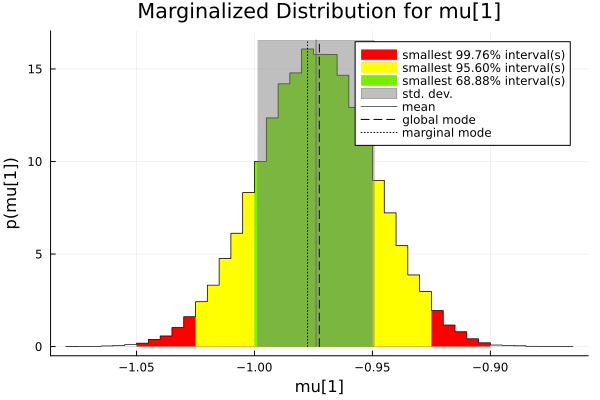

In [28]:
plot(
    samples, :(mu[1]),
    mean = true, std = true, globalmode = true, marginalmode = true,
    nbins = 50, title = "Marginalized Distribution for mu[1]"
)

or plot the marginalized distribution for a pair of parameters (e.g.
parameters 3 and 5, i.e. μ[1] and σ), including information from the parameter
stats:

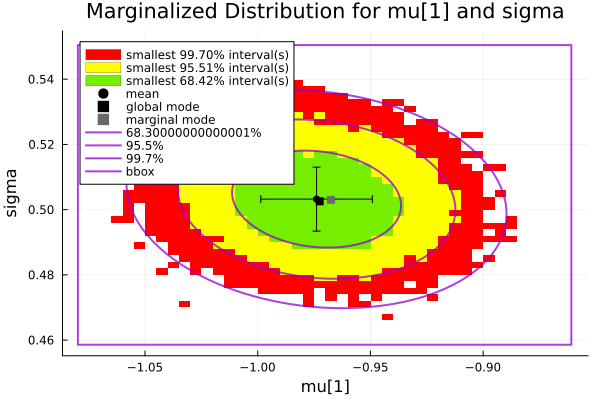

In [29]:
plot(
    samples, (:(mu[1]), :sigma),
    mean = true, std = true, globalmode = true, marginalmode = true,
    nbins = 50, title = "Marginalized Distribution for mu[1] and sigma"
)
plot!(BAT.MCMCBasicStats(samples), (3, 5))

We can also create an overview plot of the marginalized distribution for all
pairs of parameters:

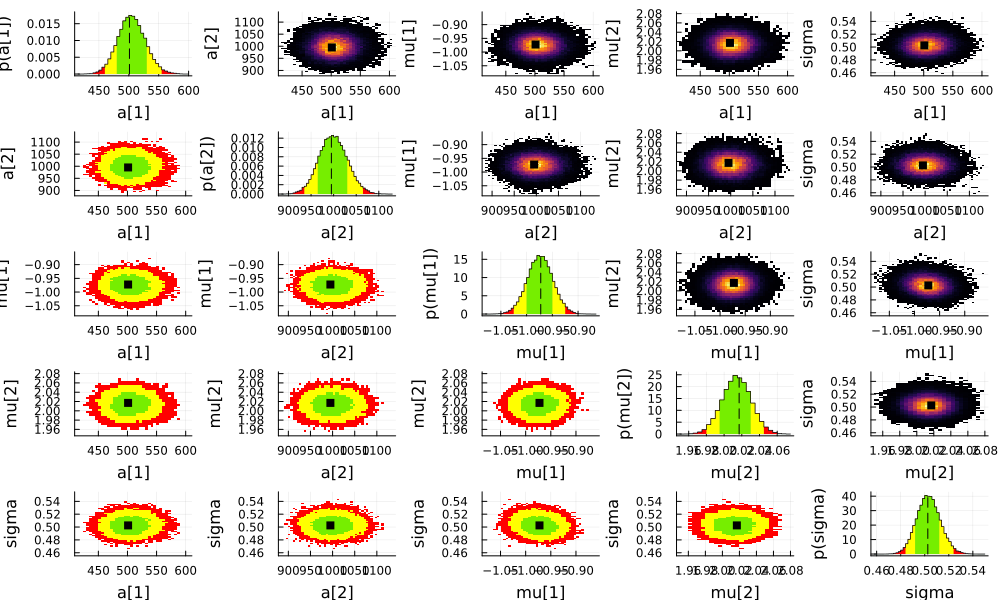

In [30]:
plot(
    samples,
    mean = false, std = false, globalmode = true, marginalmode = false,
    nbins = 50
)

### Integration with Tables.jl

`DensitySamplesVector` supports the
[Tables.jl](https://github.com/JuliaData/Tables.jl)
interface, so it is a table itself. We can also convert it to other table
types, e.g. a
[`TypedTables.Table`](http://blog.roames.com/TypedTables.jl/stable/):

In [ ]:
using TypedTables

tbl = Table(samples)

or a [`DataFrames.DataFrame`](https://github.com/JuliaData/DataFrames.jl),
etc.

## Comparison of Truth and Best Fit

As a final step, we retrieve the parameter values at the mode, representing
the best-fit parameters

In [31]:
samples_mode = mode(samples)

(a = [501.0905758889988, 995.0154152063591], mu = [-0.9725150347036633, 2.016995121300737], sigma = 0.5025512442331043)

Like the samples themselves, the result can be viewed in both shaped and
unshaped form. `samples_mode` is presented as a 0-dimensional array that
contains a NamedTuple, this representation preserves the shape information:

In [32]:
samples_mode isa NamedTuple

true

`samples_mode` is only an estimate of the mode of the posterior
distribution. It can be further refined using `bat_findmode`:

In [33]:
using Optim

findmode_result = bat_findmode(
    posterior,
    OptimAlg(optalg = Optim.NelderMead(), init = ExplicitInit([samples_mode]))
)

fit_par_values = findmode_result.result

LoadError: ArgumentError: Package Optim not found in current path.
- Run `import Pkg; Pkg.add("Optim")` to install the Optim package.

Let's plot the data and fit function given the true parameters and MCMC samples

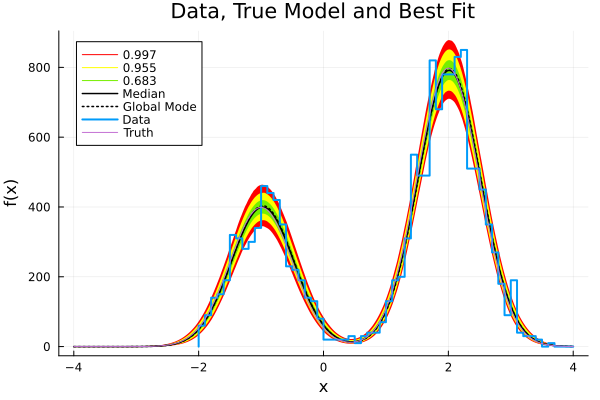

In [34]:
plot(-4:0.01:4, fit_function, samples)

plot!(
    normalize(hist, mode=:density),
    color=1, linewidth=2, fillalpha=0.0,
    st = :steps, fill=false, label = "Data",
    title = "Data, True Model and Best Fit"
)

plot!(-4:0.01:4, x -> fit_function(true_par_values, x), color=4, label = "Truth")

## Fine-grained control

BAT provides fine-grained control over the MCMC algorithm options, the
MCMC chain initialization, tuning/burn-in strategy and convergence testing.
All option value used in the following are the default values, any or all
may be omitted.

We'll sample using the The Metropolis-Hastings MCMC algorithm:

In [35]:
mcmcalgo = MetropolisHastings(
    weighting = RepetitionWeighting(),
    tuning = AdaptiveMHTuning()
)

MetropolisHastings{BAT.MvTDistProposal, RepetitionWeighting{Int64}, AdaptiveMHTuning}
  proposal: BAT.MvTDistProposal
  weighting: RepetitionWeighting{Int64} RepetitionWeighting{Int64}()
  tuning: AdaptiveMHTuning


BAT requires a counter-based random number generator (RNG), since it
partitions the RNG space over the MCMC chains. This way, a single RNG seed
is sufficient for all chains and results are reproducible even under
parallel execution. By default, BAT uses a Philox4x RNG initialized with a
random seed drawn from the
[system entropy pool](https://docs.julialang.org/en/v1/stdlib/Random/index.html#Random.RandomDevice):

In [36]:
using Random123
rng = Philox4x()
context = BATContext(rng = Philox4x())

LoadError: ArgumentError: Package Random123 not found in current path.
- Run `import Pkg; Pkg.add("Random123")` to install the Random123 package.

By default, `MetropolisHastings()` uses the following options.

For Markov chain initialization:

In [ ]:
init = MCMCChainPoolInit()

For the MCMC burn-in procedure:

In [ ]:
burnin = MCMCMultiCycleBurnin()

For convergence testing:

In [ ]:
convergence = BrooksGelmanConvergence()

To generate MCMC samples with explicit control over all options, use
something like

In [ ]:
samples = bat_sample(
    posterior,
    MCMCSampling(
        mcalg = mcmcalgo,
        nchains = 4,
        nsteps = 10^5,
        init = init,
        burnin = burnin,
        convergence = convergence,
        strict = true,
        store_burnin = false,
        nonzero_weights = true,
        callback = (x...) -> nothing
    ),
    context
).result
nothing # hide

## Saving result data to files

The package [FileIO.jl](https://github.com/JuliaIO/FileIO.jl)(in conjunction
with [JLD2.jl](https://github.com/JuliaIO/JLD2.jl)) offers a convenient way
to store results like posterior samples to file:

```julia
using FileIO
import JLD2
FileIO.save("results.jld2", Dict("samples" => samples))
```

JLD2 persists the full information (including value shapes), so you can
reload exactly the same data into memory in a new Julia session via

```julia
using FileIO
import JLD2
samples = FileIO.load("results.jld2", "samples")
```

provided you use compatible versions of BAT and it's dependencies. Note that
JLD2 is *not* a long-term stable file format. Also note that this functionality
is provided by FileIO.jl and JLD2.jl and not part of the BAT API itself.

BAT.jl itself can write samples to standard HDF5 files in a form suitable for
long-term storage (via [HDF5.jl](https://github.com/JuliaIO/HDF5.jl)):

```julia
import HDF5
bat_write("results.h5", samples)
```

The resulting files have an intuitive HDF5 layout and can be read with the
standard HDF5 libraries, so they are easily accessible from other programming
languages as well. Not all value shape information can be preserved, though.
To read BAT.jl HDF5 sample data, use

```julia
using BAT
import HDF5
samples = bat_read("results.h5").result
```

BAT.jl's HDF5 file format may evolve over time, but future versions of BAT.jl
will be able to read HDF5 sample data written by this version of BAT.jl.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*